# Lab 3: Effects of Strain on the Compressive Viscoelastic Properties of Articular Cartilage

## Goals of the Lab Report

- **Hypotheses** - What are the effects of the experimental variable (compressive
  strain) on:
  - Instantaneous modulus, $E_{0}$
  - Equilibrium Modulus, $E_{eq}$
  - Time Constant, $\tau$

- Present the $\text{mean} \pm \text{standard deviation}$ and perform statistical 
  tests for:
  - Geometric Dimensions: Diameter, Thickness
  - Contact Area (Cross-Sectional Area), $A$
  - Equilibrium Modulus, $E_{eq}$
  - Instantaneous Modulus, $E_{0}$
  - Time Constant, $\tau$
  - Stretch Parameter, $\beta$
  - % Relaxation

## Data Preprocessing and Analysis

- Truncate the data to only include the stress relaxation portion (peak force
  onwards)
- Flip the data (make the force / stress positive)
- Convert force into compressive normal stress
- Fit the data with a **stretched exponential model** of stress relaxation
  - Polydisperse polymer reptation model
    - $\sigma(t) = \left(E_0\varepsilon_0 - E_{eq}\varepsilon_0\right)\exp\left(-\left(\frac{t}{\tau}\right)^\beta\right) + E_{eq}\varepsilon_0$
    - $\sigma(t) = \varepsilon_0 \left[ (E_0 - E_{eq})\exp\left(-\left(\frac{t}{\tau}\right)^\beta\right) + E_{eq} \right]$
    - Parameters:
      - $E_0$: Instantaneous modulus
      - $E_{eq}$: Equilibrium modulus
      - $\tau$: Time constant
      - $\beta$: Stretch parameter
    - Constants:
      - $\varepsilon_0$: Constant strain
  - % Relaxation
    - $=100\% \cdot \left(1 - \frac{E_{eq}}{E_0}\right)$

In [1]:
# Google Colab: Run this to mount your Google Drive
# from google.colab import drive
# import os
# drive.mount('/content/gdrive', force_remount=True)
# os.chdir('/content/gdrive/MyDrive/BMES 301/Lab 1')

# For local only
import os; os.chdir("/home/kabil/sietch/courses/bmes301/lab3")

In [2]:
# Notebook setup

%load_ext autoreload
%autoreload 2

## Import necessary libraries
### Data analysis
from scipy import stats
import pandas as pd
import numpy as np
import tools

### Plotting
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

### Setup
from pathlib import Path
import re

## Define data path
datapath = Path("data")

## Load Data

In [3]:
# Load data
data = pd.read_csv("results/stress_relaxation_data.csv")

## Curve Fitting

In [ ]:
# Create dictionary to store parameter estimates
fitted = {
    'team': [], 
    'strain': [], 
    'E0': [],
    'Eeq': [], 
    'tau': [], 
    'beta': [],
    '% Relaxation': []
}

for team in data['team'].unique():

    ## Plot data and fit
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    for strain, ax in zip(data['strain'].unique(), axes):

        ## Subset data
        _df = (data.query(f"strain == {strain} and team == {team}")
            .reset_index(drop=True))

        ## Parameter Estimates
        E0   = _df['stress'].values[0] / strain         # E0  (MPa)
        Eeq  = _df['stress'].values[-1] / strain        # Eeq (MPa)
        tau  = _df['time'].values[-1] / np.log(E0/Eeq)  # tau (s)
        beta = 0.5                                      # beta

        ## Define objective function
        def objective(t, E0, Eeq, tau, beta):
            return strain * ( (E0 - Eeq)*np.exp( -(t/tau)**beta ) + Eeq )

        ## Fit model
        popt, _ = curve_fit(objective, _df['time'], _df['stress'], 
                            p0=[E0, Eeq, tau, beta])

        ## Calculate % Relaxation
        pct_relax = 100 * (1 - popt[1]/popt[0])

        ## Predict values based on fit
        Y_pred = objective(_df['time'], *popt)

        ## Plot data and fit
        sns.scatterplot(x=_df['time'], y=_df['stress'], ax=ax, alpha=0.5,
                        s=50, color="#34a4eb", legend=False)
        sns.lineplot(x=_df['time'], y=Y_pred, ax=ax, color="black", 
                     linewidth=2, legend=False)
        ax.set_title(f"Strain = {strain}", fontsize=14)
        ax.set_xlabel("Time (s)", fontsize=12)
        ax.set_ylabel("Stress (MPa)", fontsize=12)
        sns.despine()

        ## Store parameter estimates
        fitted['team'].append(team)
        fitted['strain'].append(strain)
        fitted['E0'].append(popt[0])
        fitted['Eeq'].append(popt[1])
        fitted['tau'].append(popt[2])
        fitted['beta'].append(popt[3])
        fitted['% Relaxation'].append(pct_relax)

    ## Plot parameter estimates
    fig.suptitle(f"Team {team}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Convert to dataframe
fitted = pd.DataFrame(fitted)

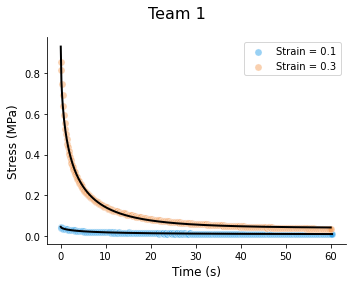

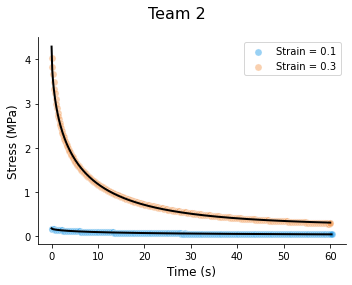

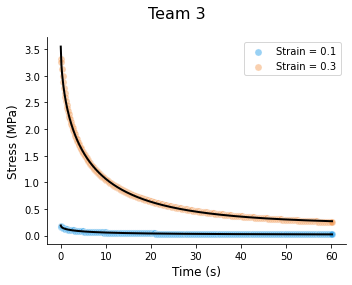

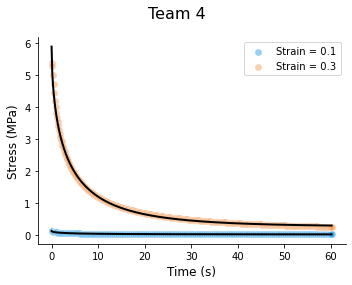

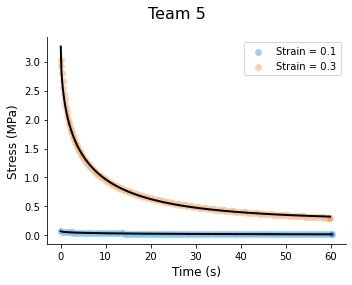

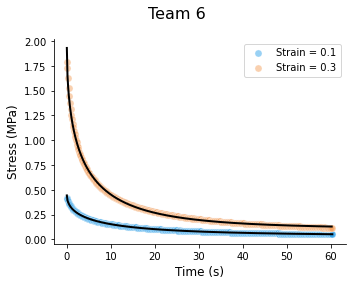

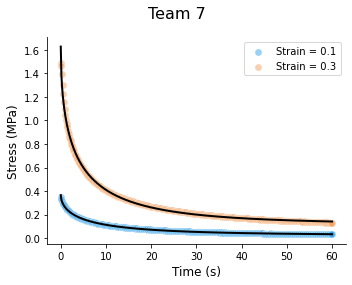

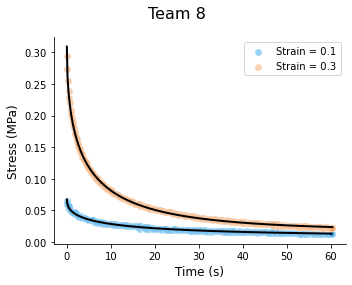

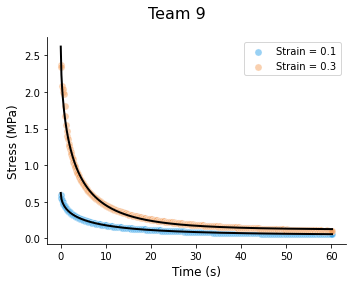

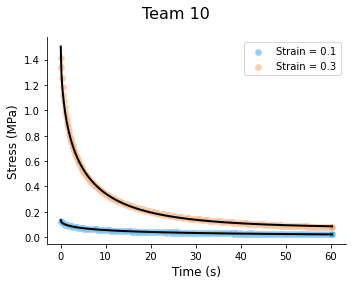

In [13]:
# Create dictionary to store parameter estimates
fitted = {
    'team': [], 
    'strain': [], 
    'E0': [],
    'Eeq': [], 
    'tau': [], 
    'beta': [],
    '% Relaxation': []
}

for team in data['team'].unique():

    ## Plot data and fit
    fig, ax = plt.subplots(figsize=(5, 4))

    for strain, color in zip(data['strain'].unique(), ["#34a4eb", "#f4a261"]):

        ## Calculate Relaxation modulus
        # E_relax = _df['stress'] / strain

        ## Subset data
        _df = (data.query(f"strain == {strain} and team == {team}")
            .reset_index(drop=True))

        ## Parameter Estimates
        E0   = _df['stress'].values[0] / strain         # E0  (MPa)
        Eeq  = _df['stress'].values[-1] / strain        # Eeq (MPa)
        tau  = _df['time'].values[-1] / np.log(E0/Eeq)  # tau (s)
        beta = 0.5                                      # beta

        ## Define objective function
        def objective(t, E0, Eeq, tau, beta):
            return strain * ( (E0 - Eeq)*np.exp( -(t/tau)**beta ) + Eeq )

        ## Fit model
        popt, _ = curve_fit(objective, _df['time'], _df['stress'], 
                            p0=[E0, Eeq, tau, beta])

        ## Calculate % Relaxation
        pct_relax = 100 * (1 - popt[1]/popt[0])

        ## Predict values based on fit
        Y_pred = objective(_df['time'], *popt)

        ## Plot data and fit
        # sns.scatterplot(x=_df['time'], y=E_relax, ax=ax, alpha=0.5,
        #                 s=50, color=color, legend=True, label=f"Strain = {strain}")
        sns.scatterplot(x=_df['time'], y=_df['stress'], ax=ax, alpha=0.5,
                        s=50, color=color, legend=True, label=f"Strain = {strain}")
        sns.lineplot(x=_df['time'], y=Y_pred, ax=ax, color="black", 
                     linewidth=2, legend=False)
        ax.set_xlabel("Time (s)", fontsize=12)
        ax.set_ylabel("Stress (MPa)", fontsize=12)
        sns.despine()

        ## Store parameter estimates
        fitted['team'].append(team)
        fitted['strain'].append(strain)
        fitted['E0'].append(popt[0])
        fitted['Eeq'].append(popt[1])
        fitted['tau'].append(popt[2])
        fitted['beta'].append(popt[3])
        fitted['% Relaxation'].append(pct_relax)

    ## Plot parameter estimates
    fig.suptitle(f"Team {team}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Convert to dataframe
fitted = pd.DataFrame(fitted)

In [5]:
mean = (fitted.iloc[:,1:]
    .groupby('strain').mean()
    .to_dict(orient='index'))
std = (fitted.iloc[:,1:]
    .groupby('strain').std()
    .to_dict(orient='index'))


for strain in [0.1, 0.3]:
    print(f"""
Strain: {strain} ({'High' if strain == 0.3 else 'Low'})
E0: {mean[strain]['E0']:0.2f} ± {std[strain]['E0']:0.2f} MPa
Eeq: {mean[strain]['Eeq']:0.2f} ± {std[strain]['Eeq']:0.2f} MPa
tau: {mean[strain]['tau']:0.2f} ± {std[strain]['tau']:0.2f} s
beta: {mean[strain]['beta']:0.2f} ± {std[strain]['beta']:0.2f}
% Relaxation: {mean[strain]['% Relaxation']:0.2f} ± {std[strain]['% Relaxation']:0.2f}%
    """)


Strain: 0.1 (Low)
E0: 2.24 ± 1.90 MPa
Eeq: 0.20 ± 0.12 MPa
tau: 7.67 ± 3.68 s
beta: 0.52 ± 0.03
% Relaxation: 88.61 ± 4.07%
    

Strain: 0.3 (High)
E0: 8.63 ± 5.62 MPa
Eeq: 0.47 ± 0.30 MPa
tau: 4.16 ± 1.04 s
beta: 0.55 ± 0.03
% Relaxation: 94.50 ± 1.23%
    


In [18]:
fitted.sort_values('strain')

,team,strain,E0,Eeq,tau,beta,% Relaxation
0,1,0.1,0.448187,0.084689,5.691535,0.556757,81.104074
2,2,0.1,1.757158,0.237171,14.503621,0.551567,86.502565
16,9,0.1,6.196234,0.430481,4.950823,0.536810,93.052544
4,3,0.1,1.909236,0.189601,4.469635,0.496360,90.069255
6,4,0.1,1.272174,0.183616,3.481500,0.507998,85.566778
14,8,0.1,0.671475,0.080379,8.618624,0.467669,88.029428
8,5,0.1,0.731508,0.111328,12.827524,0.499231,84.781079
18,10,0.1,1.345644,0.104806,9.662630,0.481317,92.211455
10,6,0.1,4.431546,0.363610,6.599705,0.537071,91.794965
12,7,0.1,3.656435,0.257574,5.847565,0.561330,92.955592


In [16]:
pd.DataFrame(stats.ttest_rel(
    fitted.query("strain == 0.1").iloc[:, 2:].values,
    fitted.query("strain == 0.3").iloc[:, 2:].values
), columns=['E0', 'Eeq', 'tau', 'beta', '% Relaxation'], index=['t', 'p-value'])

,E0,Eeq,tau,beta,% Relaxation
t,-3.388513,-2.764566,3.300278,-2.582206,-4.231433
p-value,0.008018,0.021948,0.009226,0.029589,0.002202
